# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution

In [73]:
import pandas as pd
import numpy as np
from scipy import stats

In [74]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [75]:
# number of callbacks for black-sounding names
sum(data[data.race=='b'].call)

157.0

In [76]:
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


In [77]:
data.shape

(4870, 65)

##### What test will shed some light on this?

From the hacker statistics side, we can generate bootstraps from the data and calculate the proportion of black and white-named call backs. These would then be compared to a randomly generated distribution with characteristics as if this race field did not exist.

In the frequentist camp, we can use the independent samples t-test to see if the callback rate is different between black and white-named resumes.

I somewhat prefer the predictive modeling approach. Here, using either PCA or a classifier and feature importance to see the relative role that name-race is playing so I will explore that to compare results.

The Central Limit Theorem (CLT) does apply in this case. The call-back rate of samples from this data should be normally distributed when 

-----

#### Hypotheses for testing
 
 **H<sub>0</sub>: There is no difference in call back frequency based on white or black name association on submitted resumes**
    
 **H<sub>a</sub>: Resumes submitted with black-sounding names are called back less frequently than those submitted with white-sounding names**

In [78]:
w = data[data.race == 'w']
b = data[data.race == 'b']

In [79]:
#calculate call back rate for black and white-sounding names
cbr_white = sum(data[data.race == 'w'].call) / len(data)
cbr_black = sum(data[data.race == 'b'].call) / len(data)

#calculate rate across all name-types
cbr_all = sum(data.call) / len(data)

#calculate call back rate among those called back at all
cbr_white_normed = cbr_white / cbr_all
cbr_black_normed = cbr_black / cbr_all

print('Call back rate among all resumes submitted:\n White:',
      round(cbr_white * 100, 4), '% \n Black:', round(cbr_black * 100, 4),
      '% \n Both:', round(cbr_all * 100, 4), '%\n')

print(
    'Call back rate among submitted resumes that were followed up on:\n White:',
    round(cbr_white_normed * 100, 4), '% \n Black:',
    round(cbr_black_normed * 100, 4), '% \n (Both:',
    round(cbr_all / cbr_all * 100, 4), '%)\n')
print(
    'Among all resume submissions that were followed-up on, those with black-sounding names were called back at a rate that is {}% less than those with white-sounding names'
    .format(round((cbr_white_normed - cbr_black_normed) * 100, 3)))

Call back rate among all resumes submitted:
 White: 4.8255 % 
 Black: 3.2238 % 
 Both: 8.0493 %

Call back rate among submitted resumes that were followed up on:
 White: 59.949 % 
 Black: 40.051 % 
 (Both: 100.0 %)

Among all resume submissions that were followed-up on, those with black-sounding names were called back at a rate that is 19.898% less than those with white-sounding names


----

**Resumes with black-sounding names were called back less frequently than those with white-sounding names**

Next, we test if the difference is due to an underlying signal present or just due to noise in the data. Starting with a frequentist approach, we can test if two samples, one with the call field alone of black-sounding named resumes and one with the call field of white-sounding names, means are different.

----

In [80]:
#create series for white and black sounding name call-back presences
w_frequentist = data[data.race == 'w'].call
b_frequentist = data[data.race == 'b'].call

#test black vs white call back frequency
result = stats.ttest_ind(b_frequentist, w_frequentist)

print(
    'Black-sounding named resumes were called back less frequently than white-sounding named resumes.\nTest Statistic:',
    result[0], '\n\n At a significant level:\n p value:', result[1])

Black-sounding named resumes were called back less frequently than white-sounding named resumes.
Test Statistic: -4.114705290861751 

 At a significant level:
 p value: 3.940802103128886e-05


----

**Using the t-test, the call-back frequency for black-named resumes is significantly lower than the call-back rate of white-sounding names**

We can also calculate the margin of error and confidence intervals for both white and black-sounding named call-backs

----

In [81]:
# For white-sounding names...

#set the z score of the percent confidence sought after. z of 2.33 ~ 98%
ci_z = 2.33

#set the rate of the value in question
prob = cbr_white_normed

margin_error = np.sqrt((prob * (1 - prob) / len(data))) * ci_z

#find upper and lower confidence interval values
ci_lo = prob - margin_error
ci_hi = prob + margin_error

print('For white-sounding names:\nMean:', round(prob, 4), '\nMargin of error:',
      round(margin_error, 4), '\nConfidence Interval:', round(ci_lo, 4), ',',
      round(ci_hi, 4))

For white-sounding names:
Mean: 0.5995 
Margin of error: 0.0164 
Confidence Interval: 0.5831 , 0.6159


In [82]:
# For black-sounding names...

#set the z score of the percent confidence sought after. z of 2.33 ~ 98%
ci_z = 2.33

#set the rate of the value in question
prob = cbr_black_normed

margin_error = np.sqrt((prob * (1 - prob) / len(data))) * ci_z

#find upper and lower confidence interval values
ci_lo = prob - margin_error
ci_hi = prob + margin_error

print('For black-sounding names:\nMean:', round(prob, 4), '\nMargin of error:',
      round(margin_error, 4), '\nConfidence Interval:', round(ci_lo, 4), ',',
      round(ci_hi, 4))

For black-sounding names:
Mean: 0.4005 
Margin of error: 0.0164 
Confidence Interval: 0.3841 , 0.4169


----

**To summarize while using a frequentist approach, for resumes that get a callback we can be 98% confident that:**
- **the population frequency of black-sounding names that get called back is 40% +- 1.6% of the time**
- **the population frequency of white-sounding names that get called back is 60% +- 1.6% of the time**

-----

In [83]:
#bootstrapping approach

#create function to draw replicate results
def bootstrap_result(data, func, size=1000):
    """Draw boostrap replicate from one dimensional array and return result of function as array"""
    result = np.empty(size)
    for i in range(size):
        loop_result = func(np.random.choice(data, size=len(data)))
        result[i] = loop_result
    return result

In [84]:
#bootstrap number of white-sounding call back totals and rates
w_cb_total = bootstrap_result(data[data.race == 'w'].call, sum, size=10000)

#set rate as total call-backs over length of the series it drew from
w_cb_rate = w_cb_total / len(data[data.race == 'w'].call)

#identify percentile thresholds for bootstraped samples
ci_w = np.percentile(w_cb_rate, [0.5, 98.5])

#bootstrap number of black-sounding call back totals and rates
b_cb_total = bootstrap_result(data[data.race == 'b'].call, sum, size=10000)

#set rate as total call-backs over length of the series it drew from
b_cb_rate = b_cb_total / len(data[data.race == 'b'].call)

#identify percentile thresholds for bootstraped samples
ci_b = np.percentile(b_cb_rate, [0.5, 98.5])

# #bootstrap number call-backs regardless of race
# cb_total = bootstrap_result(data.call, sum, size=10000)

# #set rate as total call-backs over length of the series it drew from
# cb_rate = cb_total/len(data.call)

print(
    'For white-sounding names:',
    'The bootstrapped frequency of call-backs is {}%'.format(
        round(np.mean(w_cb_rate) * 100, 2)),
    'We can be 99% confident the population frequency for call-backs is between:',
    round(ci_w[0] * 100, 2), '% and', round(ci_w[1] * 100, 2), '%\n\n')

print(
    'For black-sounding names:',
    'The bootstrapped frequency of call-backs is {}%'.format(
        round(np.mean(b_cb_rate) * 100, 2)),
    'We can be 99% confident the population frequency for call-backs is between:',
    round(ci_b[0] * 100, 2), '% and', round(ci_b[1] * 100, 2), '%')

For white-sounding names: The bootstrapped frequency of call-backs is 9.65% We can be 99% confident the population frequency for call-backs is between: 8.17 % and 11.01 %


For black-sounding names: The bootstrapped frequency of call-backs is 6.45% We can be 99% confident the population frequency for call-backs is between: 5.17 % and 7.56 %


-----

**Do note that the frequentist approach was normalized against the overall call through rate but I left the bootstrap approach out of overall resume pool. Both show the lower frequency of call-backs for black-sounding names as opposed to white-sounding names on resumes**

-----

### What does this testing mean?

These data show that having a black-sounding name correlates with significantly lower frequency of call-backs on submitted resumes. It could be a causal factor or not, but the result is lower call-back frequency either way. It can be tempting to think that it is the field with highest predictive power among the included fields due to social narratives on race and discrimination. It may well be the case but without exploring that further, a causal connection should not be adopted. To further test this idea, let's build a predictive model where the target feature is the "Call" field and all other variables are considered.

----

First, let's visualize any correlations between features in the dataset

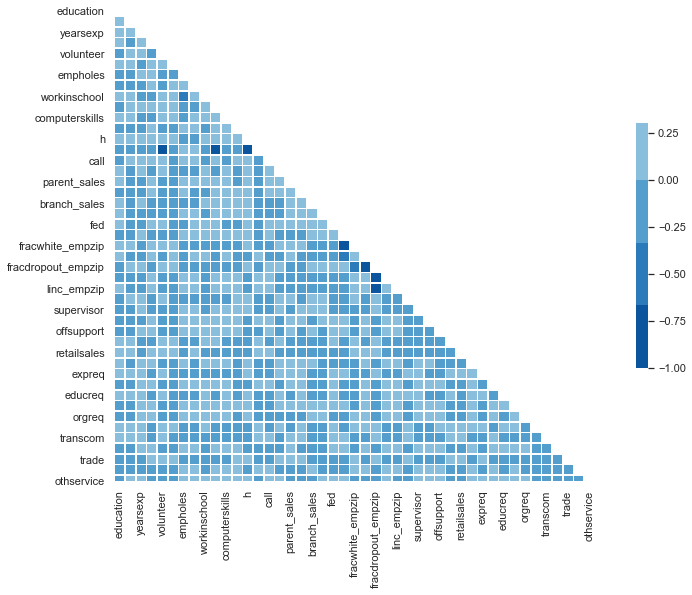

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Compute the correlation matrix
corr = data[[
    'education', 'ofjobs', 'yearsexp', 'honors', 'volunteer', 'military',
    'empholes', 'occupspecific', 'workinschool', 'email', 'computerskills',
    'specialskills', 'h', 'l', 'call', 'expminreq', 'schoolreq', 'eoe',
    'parent_sales', 'parent_emp', 'branch_sales', 'branch_emp', 'fed',
    'fracblack_empzip', 'fracwhite_empzip', 'lmedhhinc_empzip',
    'fracdropout_empzip', 'fraccolp_empzip', 'linc_empzip', 'manager',
    'supervisor', 'secretary', 'offsupport', 'salesrep', 'retailsales', 'req',
    'expreq', 'comreq', 'educreq', 'compreq', 'orgreq', 'manuf', 'transcom',
    'bankreal', 'trade', 'busservice', 'othservice', 'missind', 'ownership'
]].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.color_palette('Blues_r')

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,
            mask=mask,
            cmap=cmap,
            vmax=.3,
            center=0,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5})

That is hard to read with so many possible features. I tried starting with only those that relate to the candidate, the posting itself, and the call result. There seemed to be some others tied to geography that I will ignore for now. Without a data dictionary, it's tenuous to guess at the information some fields are capturing. Alas, this is exploratory so let's see what happens.

-----

For modeling, I'm using a random forest with some tuning because it handles a mix of categorical and continuous data fairly well. Similarly, I wont have to one hot encode a number of the categorical variables to do so and then combine their feature importances later. Scikit-Learn currently does not allow training a random forest classifier using categorical fields that have not been one-hot-encoded so we'll use h2o to do so.

In [86]:
data.to_csv('resume_discrimination.csv', index=False)

In [87]:
#random forest
import h2o
from h2o.estimators import H2ORandomForestEstimator
h2o.init()


Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,20 mins 28 secs
H2O cluster timezone:,America/Denver
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.1
H2O cluster version age:,9 days
H2O cluster name:,H2O_from_python_Stuart_Sims_18tsvl
H2O cluster total nodes:,1
H2O cluster free memory:,1.832 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


In [88]:
#read in data in a way to play nicely with h2o
data = h2o.import_file('resume_discrimination.csv')


# Input parameters that are going to train
training_columns = ['education', 'ofjobs', 'yearsexp', 'honors', 'volunteer',
       'military', 'empholes', 'occupspecific', 'workinschool',
       'email', 'computerskills', 'specialskills', 'sex', 'race',
       'h', 'l', 'expminreq',
       'schoolreq', 'manager', 'supervisor', 'secretary', 'offsupport',
       'salesrep', 'retailsales', 'req', 'expreq', 'comreq', 'educreq',
       'compreq', 'orgreq', 'manuf', 'transcom', 'bankreal', 'trade',
       'busservice', 'othservice', 'missind', 'ownership']

# Output parameter train against input parameters
response_column = 'call'

# Split data into train and testing
train, test = data.split_frame(ratios=[0.8])

# Define model
model = H2ORandomForestEstimator(ntrees=500, max_depth=20, nfolds=3)

# Train model
model.train(x=training_columns, y=response_column, training_frame=train)

# Model performance
performance = model.model_performance(test_data=test)

# performance
model._model_json['output']['variable_importances'].as_data_frame()


Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


,variable,relative_importance,scaled_importance,percentage
0,yearsexp,8059.959473,1.000000,0.097806
1,occupspecific,6509.873047,0.807681,0.078996
2,ownership,6337.235352,0.786261,0.076901
3,expminreq,5986.785645,0.742781,0.072648
4,ofjobs,4492.985352,0.557445,0.054521
5,race,3403.177979,0.422233,0.041297
6,compreq,2553.382812,0.316798,0.030985
7,busservice,2498.134277,0.309944,0.030314
8,sex,2322.870605,0.288199,0.028188
9,missind,2105.657471,0.261249,0.025552


----

**In quickly building a random forest classifier and checking feature importances, race does show up as the fifth most important feature. Without focusing on the interpretation of the importance values themselves, race falls only behind "yearsexp","ownership","expminreq","occupspecific",and "ofjobs."**

**You may be able to make some guesses as to what those fields capture but overall we can say race is certainly not ignored in the composition of features that results in a call-back.**